In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xmltodict
import numpy as np
import pandas as pd
import requests
import os
import time
import BeautifulSoup as soup
from collections import defaultdict

In [2]:
base = 'http://doubtfulnews.com/'

In [3]:
year = 2015
mon = 5
url = base
p = 4
pages = defaultdict(list)
for year in range(2014,2016):
    for mon in range(1, 13):
        p = 1
        sc = 200
        while sc == 200:
            ms = str(mon).zfill(2)
            turl = url + str(year) + '/' + ms + '/page/' + str(p) + '/'
            fname = 'pages/page_' + str(year) + '_' + ms + '_' + str(p) + '.htm'
            if not(os.path.isfile(fname)):
                r = requests.get(turl)
                sc = r.status_code
                time.sleep(1)
                f = open(fname, 'w')
                f.write(r.text.encode('utf-8'))
                f.close()
            f = open(fname, 'r')
            data = f.read()
            f.close()
            i = data.find('404 Error')
            if i == -1:
                s = soup.BeautifulSoup(data.decode('ascii', 'ignore'))
                key = str(year) + '_' + ms
                pages[key].append(s)
                p = p + 1
            else:
                sc = 0

In [4]:
totals = []
keys = []
categories = []
comments = []
for key in sorted(pages.keys()):
    plist = pages[key]
    atotal = 0
    for page in plist:
        articles = page.findAll('article')
        for article in articles:
            cattag = article.findAll('a', {'rel': 'category tag'})
            if len(cattag) > 0:
                category = cattag[0].text
            else:
                category = '?'
            categories.append(category)
            links = article.findAll('a')
            ncomments = 0
            for link in links:
                i = link.get('href').find('#comments')
                if i > 0:
                    ncomments = int(link.text.split(' ')[0])
            comments.append(ncomments)
            #.findAll('a')[1]
            #by <a href="http://doubtfulnews.com/author/idoubtit/" title="Posts by idoubtit" rel="author">idoubtit</a>&nbsp;•&nbsp;<time class="published updated" datetime="2015-05-26">May 26, 2015</time>&nbsp;•&nbsp;<a href="http://doubtfulnews.com/2015/05/what-happened-to-the-dinosaurs-they-are-used-to-indoctrinate-children/#comments">4 Comments</a>	</h2>
            # <time class="published updated" datetime="2015-05-22">May 22, 2015</time>
            #<a href="http://doubtfulnews.com/2015/05/the-kellers-wrongful-conviction-overturned-thats-not-enough/#comments">5 Comments</a>
        atotal += len(articles)
    totals.append(atotal)
    keys.append(key)

df = pd.DataFrame({'key': keys, 'total': totals})

In [5]:
df2 = pd.DataFrame({'category': categories, 'comments': comments, 'c': 1})

In [6]:
gb = df2.groupby(['category'])['comments', 'c'].sum()
gb['m'] = 1.0 * gb['comments'] / gb['c']
gb.sort('c', ascending=False, inplace=True)
gb.reset_index(inplace=True)

In [7]:
gb2 = gb[0:20].copy()
com = gb[21:gb.shape[0]].comments.sum()
c = gb[21:gb.shape[0]].c.sum()
m = 1.0 * com / c
other = pd.DataFrame([{'category': '[Other]', 'comments': com, 'c': c, 'm': m}])
gb2 = gb2.append(other)
gb2.index = np.arange(gb2.shape[0])

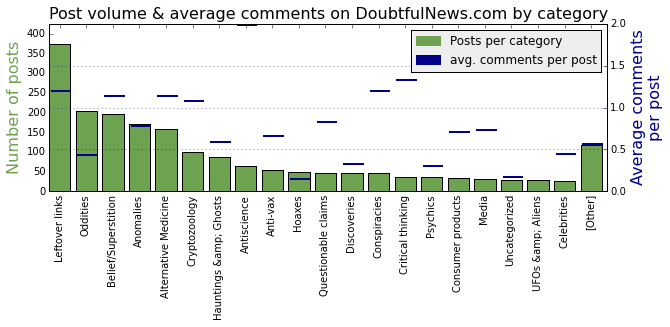

In [15]:
fig, ax1 = plt.subplots(figsize=(10,3))
#ax = fig.gca()
ax1.bar(gb2.index, gb2.c, color='#6da251', zorder=3)
plt.ylim(0, 425)
ax2 = ax1.twinx()
for i in gb2.index:
    ax2.plot([gb2.index+0.1, gb2.index+0.8], [gb2.m,gb2.m], linewidth=2, color='#000088')
ax1.set_ylabel('Number of posts', color='#6da251', fontsize=16)
ax2.set_ylabel('Average comments\nper post', fontsize=16, color='#000088')
ax2.yaxis.grid(True, color='#000088')
plt.xlim([0, len(gb2.category)])
plt.title('Post volume & average comments on DoubtfulNews.com by category', fontsize=16)
plt.xticks(gb2.index + 0.4, gb2.category.tolist(), rotation=45)

labels = ax1.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 

p1 = mpatches.Patch(color='#6da251', label='Posts per category')
p2 = mpatches.Patch(color='#000088', label='avg. comments per post')
l = plt.legend(handles=[p1, p2], loc=1)
l.set_zorder(4)
l.get_frame().set_facecolor('#eeeeee')
plt.savefig('sharon.png',bbox_inches='tight')
plt.show()